In [8]:
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader


In [9]:
class Config:
    dataset_size = 5000
    n_hidden_layers = 3    # Number of hidden layers
    width = 5              # Size of mlp's hidden layer
    lr = 1e-3             # Learning rate
    weight_deacy=0         # l2 regularization
    batch_size = 256       # Batch size
    n_epochs = 1000        # Number of epochs
    device = "cpu"         # "cuda:0" or "cpu"
    input_dim=10           # input dimensioanlity
    cross_ref=True         # if set as True - the reference set is sampled from the cross domain

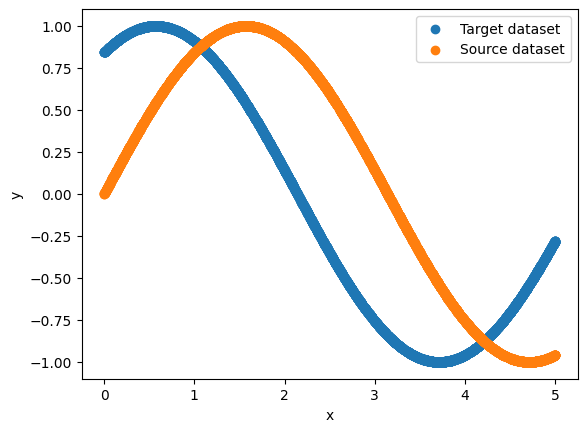

In [10]:
device = torch.device(Config.device if torch.cuda.is_available() else "cpu")

X_source = 5 * np.random.rand(Config.dataset_size, Config.input_dim)
y_source = np.sin(X_source[:,2]**1).ravel()

X_target = 5 * np.random.rand(Config.dataset_size, Config.input_dim)
y_target = np.sin(1+X_target[:,2]**1).ravel()


plt.figure()
plt.scatter(X_target[:,2], y_target, label='Target dataset' )
plt.scatter(X_source[:,2], y_source , label='Source dataset')
plt.xlabel('x'); plt.ylabel('y')
plt.legend()
plt.show()

X_source_train, X_source_test, y_source_train, y_source_test = train_test_split(
    X_source, y_source, test_size=0.33, random_state=42)
X_target_train, X_target_test, y_target_train, y_target_test = train_test_split(
    X_target, y_target, test_size=0.33, random_state=42)

In [11]:
def get_mlp(InputDim=1,LatentDim=50,OutputDim=1,Depth=3,UseBias=True):
    activation_to_use=nn.LeakyReLU()
    layers=nn.ModuleList([nn.Linear(InputDim, LatentDim, bias=UseBias)])
    layers.append(activation_to_use)
    for d in range(Depth):
        layers.append(nn.Linear(LatentDim, LatentDim, bias=UseBias))
        layers.append(activation_to_use)
    layers.append( nn.Linear(LatentDim, OutputDim, bias=UseBias))
    return nn.Sequential(*layers)

class KerAttModel(nn.Module):

     def __init__(self, InputDim=10, OutputDim=1, AttDim=5, ValueDim=5,MlpDepth=3):
         super(KerAttModel, self).__init__()
         # self.key =  get_mlp(InputDim=InputDim+OutputDim,OutputDim=AttDim,Depth=MlpDepth)
         # self.query = get_mlp(InputDim=InputDim,OutputDim=AttDim,Depth=MlpDepth)
         # self.value = get_mlp(InputDim=InputDim+OutputDim,OutputDim=ValueDim,Depth=MlpDepth)
         # self.ff = get_mlp(InputDim=ValueDim, OutputDim=OutputDim,Depth=MlpDepth)

         self.key =  get_mlp(InputDim=InputDim,OutputDim=AttDim,Depth=MlpDepth)
         self.query = get_mlp(InputDim=InputDim,OutputDim=AttDim,Depth=MlpDepth)
         self.value = get_mlp(InputDim=OutputDim,OutputDim=ValueDim,Depth=MlpDepth)
         self.ff = get_mlp(InputDim=ValueDim, OutputDim=OutputDim,Depth=MlpDepth)

     def forward(self, x_ref, y_ref, x):
         # K = self.key(torch.cat((x_ref,y_ref), dim=1))
         # Q = self.query(x)
         # V = self.value(torch.cat((x_ref,y_ref), dim=1))

         K = self.key(x_ref)
         Q = self.query(x)
         V = self.value(y_ref)

         K=F.normalize(K, p=2, dim=1)
         Q=F.normalize(Q, p=2, dim=1)

         A = nn.Softmax(dim=0)(K @ Q.T)
         pred = self.ff(A.T @ V)
         return pred


In [12]:
net = KerAttModel(InputDim=Config.input_dim, OutputDim=1, AttDim=5, ValueDim=5,MlpDepth=Config.n_hidden_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=Config.lr, weight_decay=Config.weight_deacy)

training_source_data=list(zip(X_source_train.astype('float32',casting='same_kind'),
                              y_source_train.astype('float32',casting='same_kind').reshape(-1,1)))
train_source_dataloader = DataLoader(training_source_data, batch_size=Config.batch_size, shuffle=True)
val_source_data=list(zip(X_source_test.astype('float32',casting='same_kind'),
                         y_source_test.astype('float32',casting='same_kind').reshape(-1,1)))
val_source_dataloader = DataLoader(val_source_data, batch_size=Config.batch_size, shuffle=True)

training_target_data=list(zip(X_target_train.astype('float32',casting='same_kind'),
                              y_target_train.astype('float32',casting='same_kind').reshape(-1,1)))
train_target_dataloader = DataLoader(training_target_data, batch_size=Config.batch_size, shuffle=True)
val_target_data=list(zip(X_target_test.astype('float32',casting='same_kind'),
                         y_target_test.astype('float32',casting='same_kind').reshape(-1,1)))
val_target_dataloader = DataLoader(val_target_data, batch_size=Config.batch_size, shuffle=True)

TrainLosses=[]
SourceValLosses,TargetValLosses=[],[]
pbar= tqdm(range(Config.n_epochs))
for ind in pbar:
    optimizer.zero_grad()

    x_ref_source, y_ref_source = next(iter(train_source_dataloader))
    x_ref_target, y_ref_target = next(iter(train_target_dataloader))
    x_source, y_source = next(iter(train_source_dataloader))
    x_target, y_target = next(iter(train_target_dataloader))
    if Config.cross_ref:
        pred_target = net(x_ref_source, y_ref_source, x_target)
        loss_target = criterion(pred_target, y_target)
        pred_source = net(x_ref_target, y_ref_target, x_source)
        loss_source = criterion(pred_source, y_source)
    else:
        pred_source = net(x_ref_source, y_ref_source, x_source)
        loss_source = criterion(pred_source, y_source)
        pred_target = net(x_ref_target, y_ref_target, x_target)
        loss_target = criterion(pred_target, y_target)

    loss=loss_source+loss_target
    loss.backward()
    optimizer.step()
    TrainLosses.append(loss.item())

    with torch.no_grad():
        x_source, y_source = next(iter(val_source_dataloader))
        x_target, y_target = next(iter(val_target_dataloader))

        if Config.cross_ref:
            pred_target = net(x_ref_source, y_ref_source, x_target)
            loss_target = criterion(pred_target, y_target)
            pred_source = net(x_ref_target, y_ref_target, x_source)
            loss_source = criterion(pred_source, y_source)
        else:
            pred_source = net(x_ref_source, y_ref_source, x_source)
            loss_source = criterion(pred_source, y_source)
            pred_target = net(x_ref_target, y_ref_target, x_target)
            loss_target = criterion(pred_target, y_target)

        SourceValLosses.append(loss_source.item())
        TargetValLosses.append(loss_target.item())

    pbar.set_description('TrainLoss:%.3g,ValSourceLoss:%.3g,ValTargetLoss:%.3g'
                         %(TrainLosses[-1],SourceValLosses[-1],TargetValLosses[-1]))

TrainLoss:0.116,ValSourceLoss:0.0834,ValTargetLoss:0.01: 100%|██████████| 1000/1000 [01:04<00:00, 15.53it/s]    


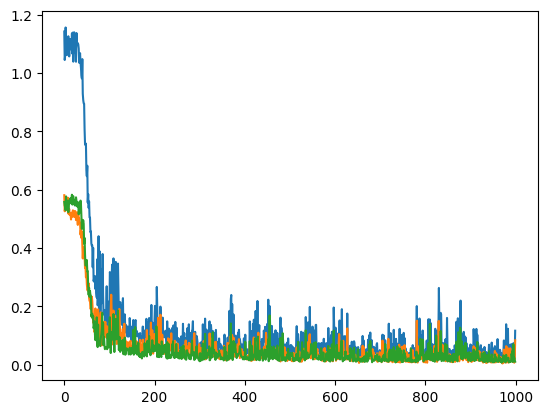

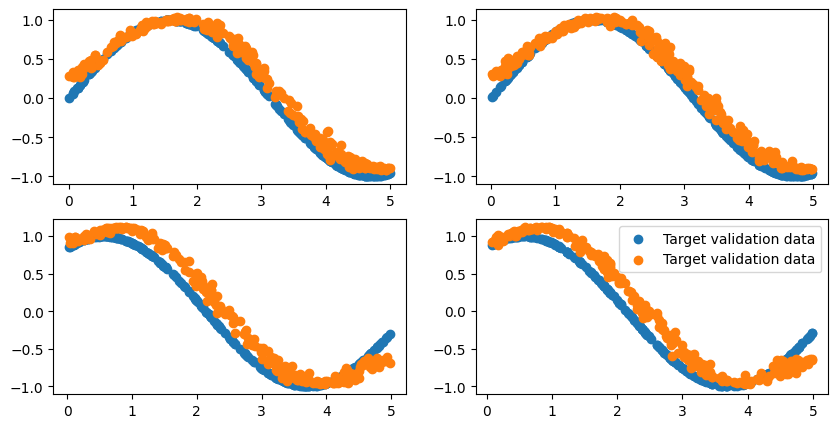

In [13]:
plt.figure()
plt.plot(TrainLosses)
plt.plot(SourceValLosses)
plt.plot(TargetValLosses)
plt.show()

x_ref_source, y_ref_source = next(iter(train_source_dataloader))
x_ref_target, y_ref_target = next(iter(train_target_dataloader))
x_train_source, y_train_source = next(iter(train_source_dataloader))
x_train_target, y_train_target = next(iter(train_target_dataloader))
x_val_source, y_val_source = next(iter(val_source_dataloader))
x_val_target, y_val_target = next(iter(val_target_dataloader))

if Config.cross_ref:
    pred_train_target = net(x_ref_source, y_ref_source, x_train_target)
    pred_train_source = net(x_ref_target, y_ref_target, x_train_source)
    pred_val_target = net(x_ref_source, y_ref_source, x_val_target)
    pred_val_source = net(x_ref_target, y_ref_target, x_val_source)
else:
    pred_train_target = net(x_ref_target, y_ref_target, x_train_target)
    pred_train_source = net(x_ref_source, y_ref_source, x_train_source)
    pred_val_target = net(x_ref_target, y_ref_target, x_val_target)
    pred_val_source = net(x_ref_source, y_ref_source, x_val_source)


plt.figure(figsize=(10,5))
plt.subplot(221)
plt.scatter(x_train_source.detach().cpu()[:,2],y_train_source.detach().cpu(),label='Source training data')
plt.scatter(x_train_source.detach().cpu()[:,2], pred_train_source.detach().cpu(),label='Source training predictions')
plt.subplot(222)
plt.scatter(x_val_source.detach().cpu()[:,2],y_val_source.detach().cpu(),label='Source validation data')
plt.scatter(x_val_source.detach().cpu()[:,2], pred_val_source.detach().cpu(),label='Source validation predictions')
plt.subplot(223)
plt.scatter(x_train_target.detach().cpu()[:,2],y_train_target.detach().cpu(),label='Target training data')
plt.scatter(x_train_target.detach().cpu()[:,2], pred_train_target.detach().cpu(),label='Target training data')
plt.subplot(224)
plt.scatter(x_val_target.detach().cpu()[:,2],y_val_target.detach().cpu(),label='Target validation data')
plt.scatter(x_val_target.detach().cpu()[:,2], pred_val_target.detach().cpu(),label='Target validation data')
plt.legend()
plt.show()

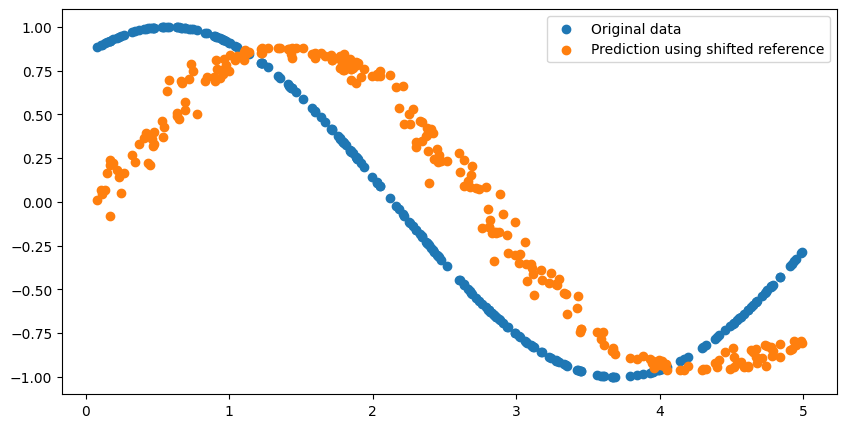

In [14]:
x_ref_source, y_ref_source = next(iter(train_source_dataloader))
x_ref_source=x_ref_source-1
x_ref_target, y_ref_target = next(iter(train_target_dataloader))
x_ref_target=x_ref_target-1
if Config.cross_ref:
    pred_val_target = net(x_ref_source, y_ref_source, x_val_target)
else:
    pred_val_target = net(x_ref_target, y_ref_target, x_val_target)

plt.figure(figsize=(10,5))
plt.scatter(x_val_target.detach().cpu()[:,2],y_val_target.detach().cpu(),label='Original data')
plt.scatter(x_val_target.detach().cpu()[:,2], pred_val_target.detach().cpu(),label='Prediction using shifted reference')
plt.legend()
plt.show()